In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

/home/oliver/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Text(0, 0.5, 'Digital units')

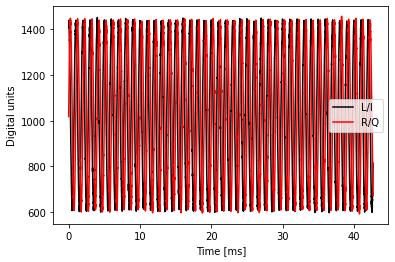

In [2]:
N = 2048*2*2
fs = 192e3
t = np.arange(N) / fs
ftone = 1000
i = 0.2*np.cos(2*np.pi*(ftone)*t)+np.random.randn(N)/300
q = 0.2*np.sin(2*np.pi*(ftone)*t)+np.random.randn(N)/300
si = (i*2048+1024).astype(int)
sq = (q*2048+1024).astype(int)
fle = "mock_L_data_int_1khz.c"
fout = open(fle,'w')
fout.write("int16_t L_mock_1khz[%d] = {"%N)
for k in range(N-1):
    fout.write("%d,"%si[k]);
fout.write("%d};\n"%(si[N-1]))
fout.close()

fle = "mock_R_data_int_1khz.c"
fout = open(fle,'w')
fout.write("int16_t R_mock_1khz[%d] = {"%N)
for k in range(N-1):
    fout.write("%d,"%(sq[k]));
fout.write("%d};\n"%(sq[N-1]))
fout.close()

plt.figure()
plt.plot(t*1000,si,'k-',label='L/I')
plt.plot(t*1000,sq,'r-',label='R/Q')
plt.legend()
plt.xlabel("Time [ms]")
plt.ylabel('Digital units')

Text(0, 0.5, 'Digital units')

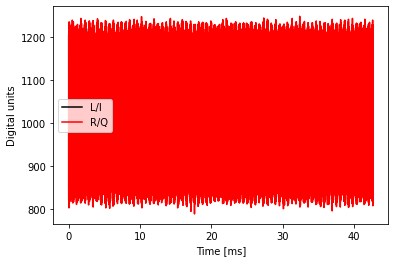

In [18]:
N = 2048*2*2
fs = 192e3
t = np.arange(N) / fs
ftone = 440
if False:
    i = 0.9*0.1*np.cos(2*np.pi*(-48000-ftone)*t)+np.random.randn(N)/300
    q = 0.1*np.sin(2*np.pi*(-48000-ftone)*t+5*np.pi/180)+np.random.randn(N)/300
    si = (i*2048+1024).astype(int)
    sq = (q*2048+1024).astype(int)
    fle = "mock_L_data_int.c"
    fout = open(fle,'w')
    fout.write("int16_t L_mock[%d] = {"%N)
    for k in range(N-1):
        fout.write("%d,"%si[k]);
    fout.write("%d};\n"%(si[N-1]))
    fout.close()
    
    fle = "mock_R_data_int.c"
    fout = open(fle,'w')
    fout.write("int16_t R_mock[%d] = {"%N)
    for k in range(N-1):
        fout.write("%d,"%(sq[k]));
    fout.write("%d};\n"%(sq[N-1]))
    fout.close()
else:
    L = open('mock_L_data_int.c','r').readline()
    Lvals = L.split('=')[1].strip().strip(';{}').split(',')
    si = np.array([int(a) for a in Lvals])
    
    R = open('mock_R_data_int.c','r').readline()
    Rvals = R.split('=')[1].strip().strip(';{}').split(',')
    sq = np.array([int(a) for a in Rvals])

plt.figure()
plt.plot(t*1000,si,'k-',label='L/I')
plt.plot(t*1000,sq,'r-',label='R/Q')
plt.legend()
plt.xlabel("Time [ms]")
plt.ylabel('Digital units')

Text(0, 0.5, 'Power [dB]')

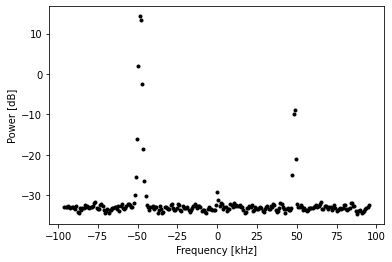

In [19]:
data = si + 1j*sq
f,Pxx = welch(data,fs=fs,return_onesided=False)
plt.figure()
plt.plot(f/1000,10*np.log10(Pxx),'k.')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Power [dB]')

In [20]:
def phase_correction(I,Q,phs):
    if phs < 0:
        corr = phs*I
        Qcorr = Q + corr
        return I,Qcorr
    else:
        corr = phs*Q
        Icorr = I + corr
        return Icorr,Q

def apply_correction(I,Q,amp,phs):
    Icorr = I*amp
    return phase_correction(Icorr,Q,phs)

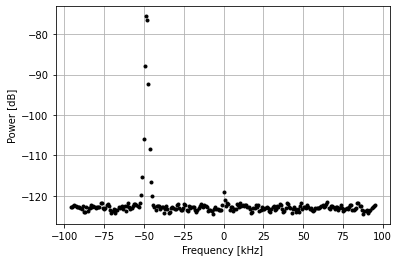

In [21]:
Icorr,Qcorr = apply_correction(si/32768,sq/32768,1.11,-0.09)
dataC = Icorr+1j*Qcorr
fc,Pc = welch(dataC,fs=fs,return_onesided=False)
plt.figure()
plt.plot(fc/1000,10*np.log10(Pc),'k.')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Power [dB]')
plt.grid()

In [22]:
fle = "mock_I_data_IQcorrected.c"
fout = open(fle,'w')
fout.write("float32_t I_corrected[%d] = {"%N)
for k in range(N-1):
    fout.write("%7.6f,"%Icorr[k]);
fout.write("%7.6f};\n"%(Icorr[N-1]))
fout.close()

fle = "mock_Q_data_IQcorrected.c"
fout = open(fle,'w')
fout.write("float32_t Q_corrected[%d] = {"%N)
for k in range(N-1):
    fout.write("%7.6f,"%(Qcorr[k]));
fout.write("%7.6f};\n"%(Qcorr[N-1]))
fout.close()

In [23]:
I = np.array([+1, 0,-1, 0]*128)
Q = np.array([ 0,-1, 0,+1]*128)
d = I + 1j*Q
D = np.fft.fft(d)
print("%d,%f"%(np.argmax(np.real(D)),np.abs(D[384])))

384,512.000000


In [24]:
I = np.array([+1, 0,-1, 0]*128)
Q = np.array([ 0,-1, 0,+1]*128)
d = I + 1j*Q
D = np.fft.fft(d)*np.hanning(512)
print("%d,%f"%(np.argmax(np.real(D)),np.abs(D[384])))

384,253.639228
